# NYC Harasment Complaints Data Analysis

This notebook contains snippets that intend to dive into the [NYC Complaints data set](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-YTD/5uac-w243) and investigate trends of complaints about harasment (all records where PD_DESC ctonains the work HARASMENT). I am particulraly interested in seeing whether there are any significant changes and trends during the presidential election campaign, as well as after the outcome of the presidential election.

In [1]:
%matplotlib inline
import pandas
import folium
import datetime 
import zipfile
import matplotlib
import matplotlib.pyplot as plt

# unzipping raw csv file
DATA_FILE_PATH = 'NYPD_Complaint_Data_Current_YTD.csv'
zip_ref = zipfile.ZipFile('NYPD_Complaint_Data_Current_YTD.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

In [2]:
# parsing data
fullData = pandas.read_csv(DATA_FILE_PATH, sep=',')
print(str(len(fullData)) + ' records in the original data set.')

# parsing dates
fullData['CMPLNT_FR_DT'] = pandas.to_datetime(fullData['CMPLNT_FR_DT'], errors='ignore', format='%m/%d/%Y')
fullData['CMPLNT_TO_DT'] = pandas.to_datetime(fullData['CMPLNT_TO_DT'], errors='ignore', format='%m/%d/%Y')

# select 2016 only
fullData = fullData[fullData['CMPLNT_FR_DT'].str.contains('2016')==True]
fullData['CMPLNT_FR_DT']
print(str(len(fullData)) + ' records in the 2016 data.')
fullData = fullData.sort_values(['CMPLNT_FR_DT'], ascending=True)
fullData['COUNT'] = 1

478804 records in the original data set.
468290 records in the 2016 data.


### General Complaint Types
First we look at the different description types of complaints in general in 2016:

There are 351 diffreent description types in the data set


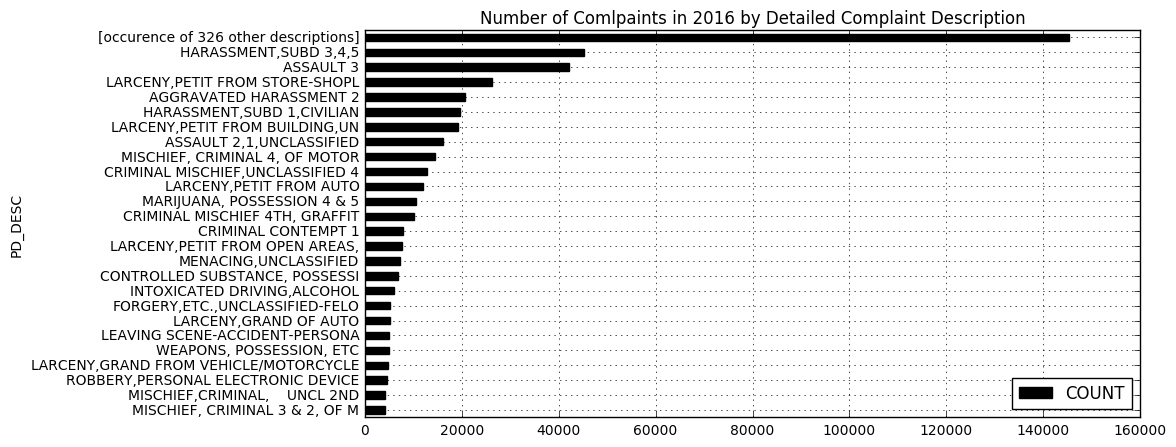

In [3]:
# summing all description types
descriptionTypeCount = len(fullData['PD_DESC'].value_counts())
print('There are ' + str(descriptionTypeCount) + ' diffreent description types in the data set')
descriptionAllTotals = pandas.DataFrame(fullData.groupby(['PD_DESC'])['COUNT'].sum())

#setting boundries for the chart
head = 25
tail = descriptionTypeCount - head

# summing all descriptions that aren't in the top records
descriptionAllTotals = descriptionAllTotals.sort_values(['COUNT'], ascending=False)
descriptionTopTotals = descriptionAllTotals.head(head).reset_index()
otherDescriptionsAmount = descriptionAllTotals.tail(tail)['COUNT'].sum()
otherDescriptionsRow = pandas.DataFrame(
    [['[occurence of '+str(tail)+' other descriptions]', otherDescriptionsAmount]], 
    columns=['PD_DESC', 'COUNT'])
descriptionTotals = descriptionTopTotals.append(otherDescriptionsRow)

# plot the description amounts
plt.rcParams["figure.figsize"] = [10,5]
descriptionTotals = descriptionTotals.sort_values(['COUNT'], ascending=True)
descriptionTotals = descriptionTotals.set_index('PD_DESC')
descriptionTotals.plot.barh(facecolor='k');
plt.title('Number of Comlpaints in 2016 by Detailed Complaint Description')
plt.grid()

Displaying the sum of the top 25 complaint types of 2016 in the chart above, we can see that harasment complaints are the most common complaint, particulary the 'HARASMENT,SUB 3,4,5' type. The other harasment type ('HARASMENT,SUBD 1,CILIVIAN) is the fith common complaint type in 2016. We can also see that there is very a long tail of 326 different complaint types. 

Furthermore, it looks like many complaint types are very detailled strings with the main type at the beginning and more detail after a comma. To reduce the complexity of this data set, we will only look at complaint type strings before the comma and sum all records with the same overall complaint type.

After simplifying complaint types, there are now 198 diffreent description types in the data set


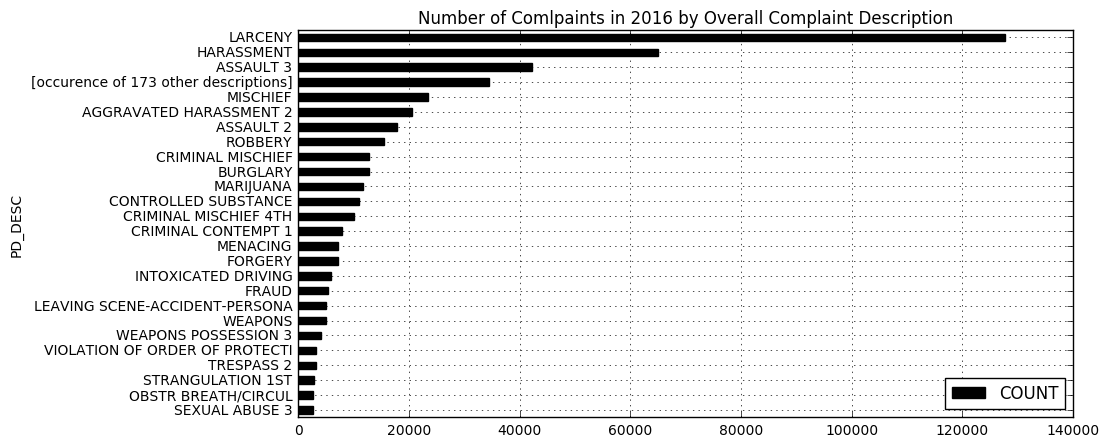

In [4]:
# parse PD_DESC to only look at string before comma
fullData['PD_DESC_full'] = fullData['PD_DESC']
fullData['PD_DESC'] = fullData['PD_DESC'].str.split(',').str[0]
descriptionTypeCount = len(fullData['PD_DESC'].value_counts())
print('After simplifying complaint types, there are now ' + str(descriptionTypeCount) + ' diffreent description types in the data set')
descriptionAllTotals = pandas.DataFrame(fullData.groupby(['PD_DESC'])['COUNT'].sum())

#setting boundries for the chart
head = 25
tail = descriptionTypeCount - head

# combining all description that aren't in the top records
descriptionAllTotals = descriptionAllTotals.sort_values(['COUNT'], ascending=False)
descriptionTopTotals = descriptionAllTotals.head(head).reset_index()
otherDescriptionsAmount = descriptionAllTotals.tail(tail)['COUNT'].sum()
otherDescriptionsRow = pandas.DataFrame([['[occurence of '+str(tail)+' other descriptions]', otherDescriptionsAmount]], columns=['PD_DESC', 'COUNT'])
descriptionTotals = descriptionTopTotals.append(otherDescriptionsRow)

# plot the description amounts
plt.rcParams["figure.figsize"] = [10,5]
descriptionTotals = descriptionTotals.sort_values(['COUNT'], ascending=True)
descriptionTotals = descriptionTotals.set_index('PD_DESC')
descriptionTotals.plot.barh(facecolor='k');
plt.title('Number of Comlpaints in 2016 by Overall Complaint Description')
plt.grid()

We can see now that Larceny is taken the top of the most commen overall complaint, followed by Harassment and Assault 3. We have summarised the 351 different complaint types into 198 overall complaint types.

Now let's look at the data points over time. Below we can see the daily, weekly, monthly and quarterly total amount of complaints, as well as each time aggregation's minimum, maximum, mean and average value.

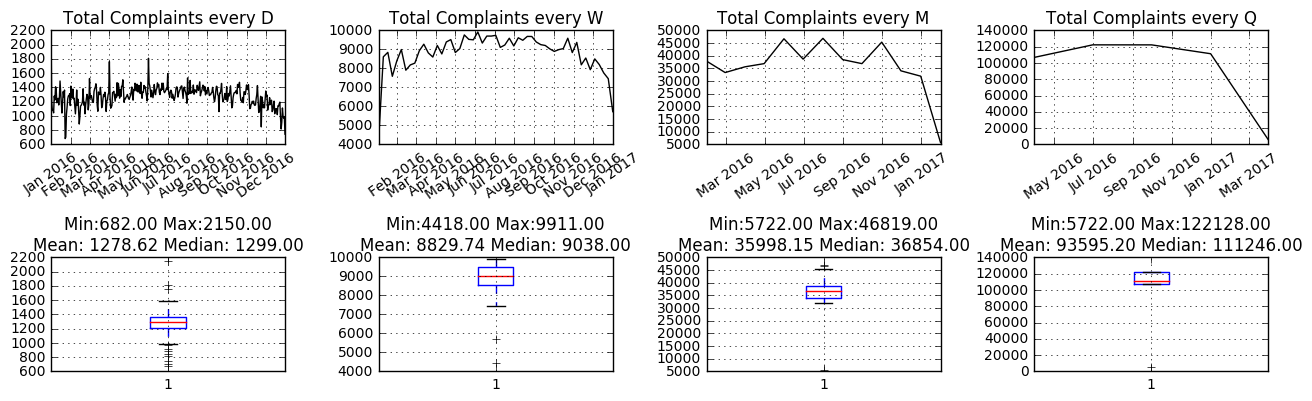

In [5]:
# TO DO: remove 2017 data point!

plt.rcParams["figure.figsize"] = [13,13]

fullDataTimeSeries = pandas.DataFrame(fullData.groupby(['CMPLNT_FR_DT','PD_DESC'])['COUNT'].sum()).reset_index()
fullDataTimeSeries = fullDataTimeSeries.sort_values(['CMPLNT_FR_DT'])
monthlyfullDataTimeSeries = fullDataTimeSeries.set_index(pandas.DatetimeIndex(fullDataTimeSeries['CMPLNT_FR_DT']))

timeAggs = ['D','W','M','Q']
i = 1

for timeAgg in timeAggs:
    monthlyfullDataTimeSeries = monthlyfullDataTimeSeries.resample(timeAgg).sum()
    plt.subplot(6, 4, i)
    plt.tight_layout()
    plt.xticks(rotation=35)
    plt.title('Total Complaints every '+timeAgg)
    plt.plot(monthlyfullDataTimeSeries, 'k-')
    plt.grid()
    plt.subplot(6, 4, i+4)
    plt.tight_layout()
    plt.boxplot(monthlyfullDataTimeSeries['COUNT'])
    plt.title('Min:'+str('%.2f' % monthlyfullDataTimeSeries.min().COUNT)+' Max:'+str('%.2f' % monthlyfullDataTimeSeries.max().COUNT)+'\nMean: '+str('%.2f' % monthlyfullDataTimeSeries.mean().COUNT)+' Median: '+str('%.2f' % monthlyfullDataTimeSeries.median().COUNT))
    plt.grid()
    i+=1

In the charts below, we dig deeper into each monthly time series of total complaints for the top 25 complaint types of the 198 simplified complaint strings in the data set. The charts also show by how much percent the complaints changed each month, as well as the minimum, maximum, mean and average of the total monthly amount and monthyl percent change for each complaint type.

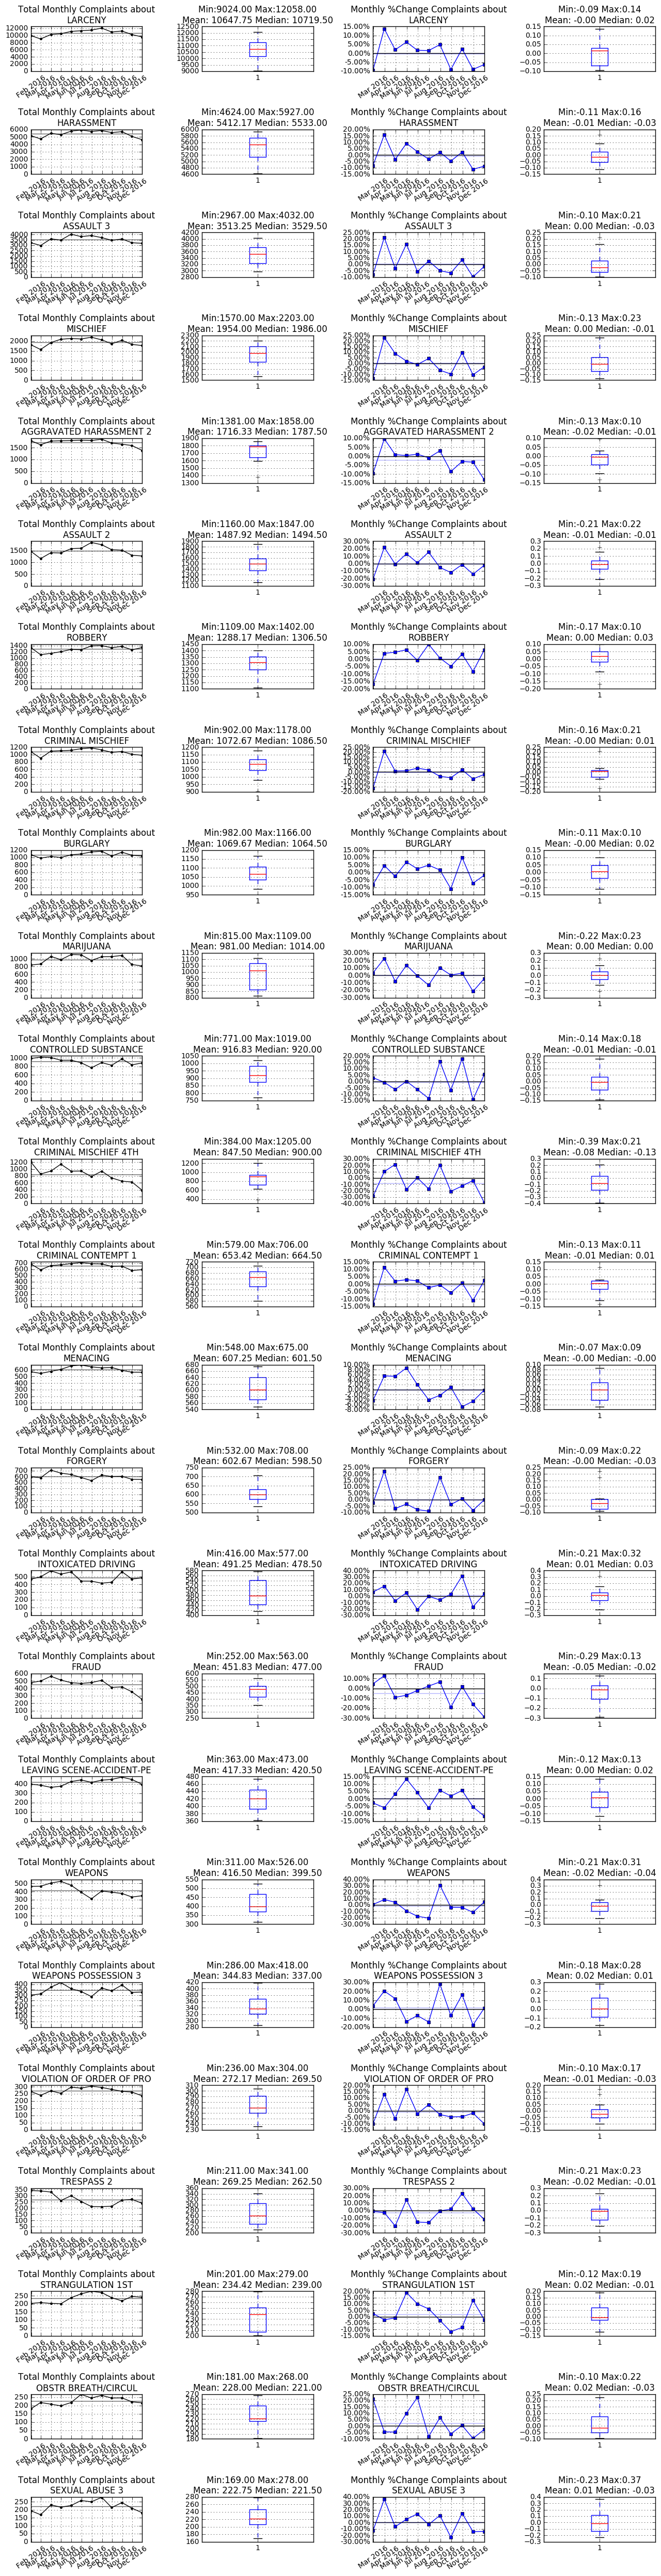

In [6]:
descArr = descriptionAllTotals.reset_index()['PD_DESC'].tolist()
descArr = descArr[:25]
plt.rcParams["figure.figsize"] = [13,len(descArr)*2]
plt.title('Monthly Total and % Change of Number of Harrasment Complaints per Reported Location')
i = 1

for desc in descArr:
    tempDF = pandas.DataFrame(fullDataTimeSeries[(fullDataTimeSeries['PD_DESC'] == desc)]) 
    tempDF = tempDF.set_index(pandas.DatetimeIndex(tempDF['CMPLNT_FR_DT']))
    tempDF = tempDF.resample("M").sum()
    plt.subplot(len(descArr), 4, i)
    plt.tight_layout()
    plt.plot(tempDF, 'k.', tempDF, 'k-')
    plt.xticks(rotation=35)
    descTitle = desc[:25]
    plt.title('Total Monthly Complaints about\n'+descTitle)
    plt.ylim(ymin=0)
    plt.grid()
    plt.axhline(tempDF.COUNT.mean(), color='black', alpha=0.6)
    i+=1       
    plt.subplot(len(descArr), 4, i)
    plt.tight_layout()
    plt.boxplot(tempDF['COUNT'])
    plt.title('Min:'+str('%.2f' % tempDF.min().COUNT)+' Max:'+str('%.2f' % tempDF.max().COUNT)+'\nMean: '+str('%.2f' % tempDF.mean().COUNT)+' Median: '+str('%.2f' % tempDF.median().COUNT))
    plt.grid()
    i+=1
    tempDF = tempDF.pct_change();
    ax = plt.subplot(len(descArr), 4, i)
    plt.plot(tempDF, 'bs', tempDF, 'b-', markersize=5)
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.title('Monthly %Change Complaints about\n'+descTitle)
    plt.grid()
    plt.axhline(0, color='black')
    plt.axhline(tempDF.COUNT.mean(), color='blue', alpha=0.3)
    plt.axhline(0, color='black', alpha=0.2)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
    i+=1
    plt.subplot(len(descArr), 4, i)
    plt.tight_layout()
    plt.boxplot(tempDF['COUNT'].fillna(0))
    plt.title('Min:'+str('%.2f' % tempDF.min().COUNT)+' Max:'+str('%.2f' % tempDF.max().COUNT)+'\nMean: '+str('%.2f' % tempDF.mean().COUNT)+' Median: '+str('%.2f' % tempDF.median().COUNT))
    plt.grid()
    i+=1

### Harasment Locations
Looking only at harasment complaints and breaking the data down by their reported location, we can below see that the vast majroity of harasment appears to happen within a residential house or apartment. "Street" is third most common location reported harasment appears to take place.

In [9]:
# select harassment records only 
harassmentData = fullData[fullData['PD_DESC'].str.contains("HARASSMENT")==True].sort_values(['CMPLNT_FR_DT'])
print(str(len(harassmentData)) + ' records in the 2016 harassment data.')

85791 records in the 2016 harassment data.


There are 70 diffreent location types in the data set


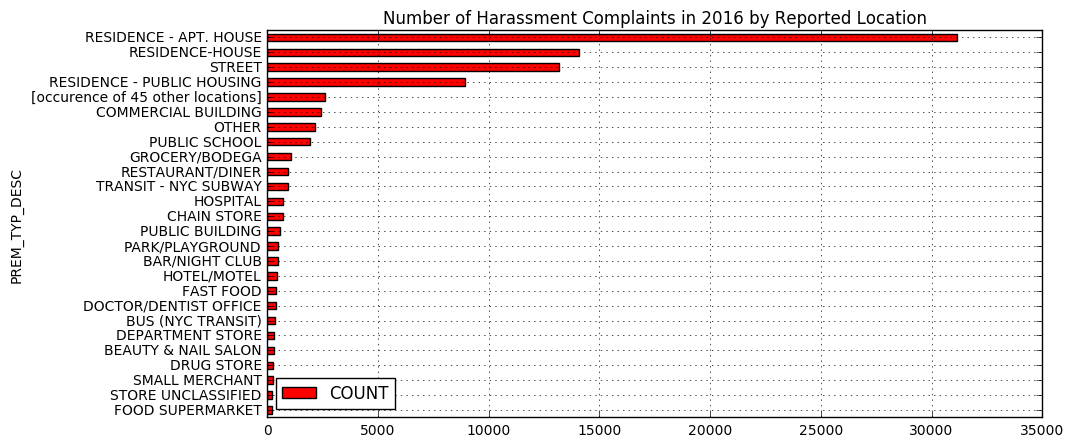

In [49]:
locationTypeCount = len(harassmentData['PREM_TYP_DESC'].value_counts())
print('There are ' + str(locationTypeCount) + ' diffreent location types in the data set')

harassmentDataTotals = pandas.DataFrame(harassmentData.groupby(['PREM_TYP_DESC'])['COUNT'].sum())

#setting boundries for the chart
head = 25
tail = locationTypeCount - head

# combining all location types that aren't in the top records
harassmentDataTotals = harassmentDataTotals.sort_values(['COUNT'], ascending=False)
harassmentDataTopTotals = harassmentDataTotals.head(25)
otherLocationAmount = harassmentDataTotals.tail(locationTypeCount-25)['COUNT'].sum()
otherLocationRow = pandas.DataFrame([['[occurence of '+str(tail)+' other locations]', otherLocationAmount]], columns=['PREM_TYP_DESC', 'COUNT']).set_index('PREM_TYP_DESC')
harassmentDataFilteredTotals = harassmentDataTopTotals.append(otherLocationRow)

# plot the location amounts
plt.rcParams["figure.figsize"] = [10,5]
harassmentDataFilteredTotals = harassmentDataFilteredTotals.sort_values(['COUNT'], ascending=True)
harassmentDataFilteredTotals.plot.barh(facecolor='r');
plt.title('Number of Harassment Complaints in 2016 by Reported Location')
plt.grid()

Looking at the weekly and monthly trends and means, we can see that there are on average 235 harasment complaints each day, 1612 each week and 6446 every month. August has been the month with the most harasment complaints in 2016 so far. There does not seem to be an increase between Q2 and Q3 and we have no data for Q4 yet.

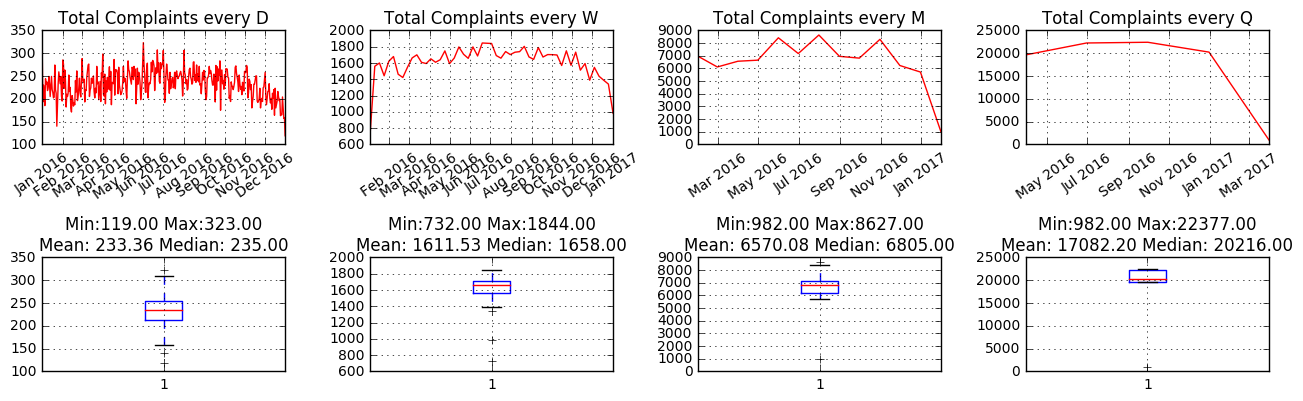

In [50]:
# TO DO: remove 2017 data point!

plt.rcParams["figure.figsize"] = [13,13]

harassmentDataTimeSeries = pandas.DataFrame(harassmentData.groupby(['CMPLNT_FR_DT','PREM_TYP_DESC'])['COUNT'].sum()).reset_index()
harassmentDataTimeSeries = harassmentDataTimeSeries.sort_values(['CMPLNT_FR_DT'])
monthlyHarassmentDataTimeSeries = harassmentDataTimeSeries.set_index(pandas.DatetimeIndex(harassmentDataTimeSeries['CMPLNT_FR_DT']))

timeAggs = ['D','W','M','Q']
i = 1

for timeAgg in timeAggs:
    monthlyHarassmentDataTimeSeries = monthlyHarassmentDataTimeSeries.resample(timeAgg).sum()
    plt.subplot(6, 4, i)
    plt.tight_layout()
    plt.xticks(rotation=35)
    plt.title('Total Complaints every '+timeAgg)
    plt.plot(monthlyHarassmentDataTimeSeries, 'r-')
    plt.grid()
    plt.subplot(6, 4, i+4)
    plt.tight_layout()
    plt.boxplot(monthlyHarassmentDataTimeSeries['COUNT'])
    plt.title('Min:'+str('%.2f' % monthlyHarassmentDataTimeSeries.min().COUNT)+' Max:'+str('%.2f' % monthlyHarassmentDataTimeSeries.max().COUNT)+'\nMean: '+str('%.2f' % monthlyHarassmentDataTimeSeries.mean().COUNT)+' Median: '+str('%.2f' % monthlyHarassmentDataTimeSeries.median().COUNT))
    plt.grid()
    i+=1

Digging through the small multiples above that show the weekly and monthly trend of harasment complaints for each location, we can see that most amounts stay relatively consistent over time. However, '**Street**' and '**Playground**' seem to be have been rising throughout the year.

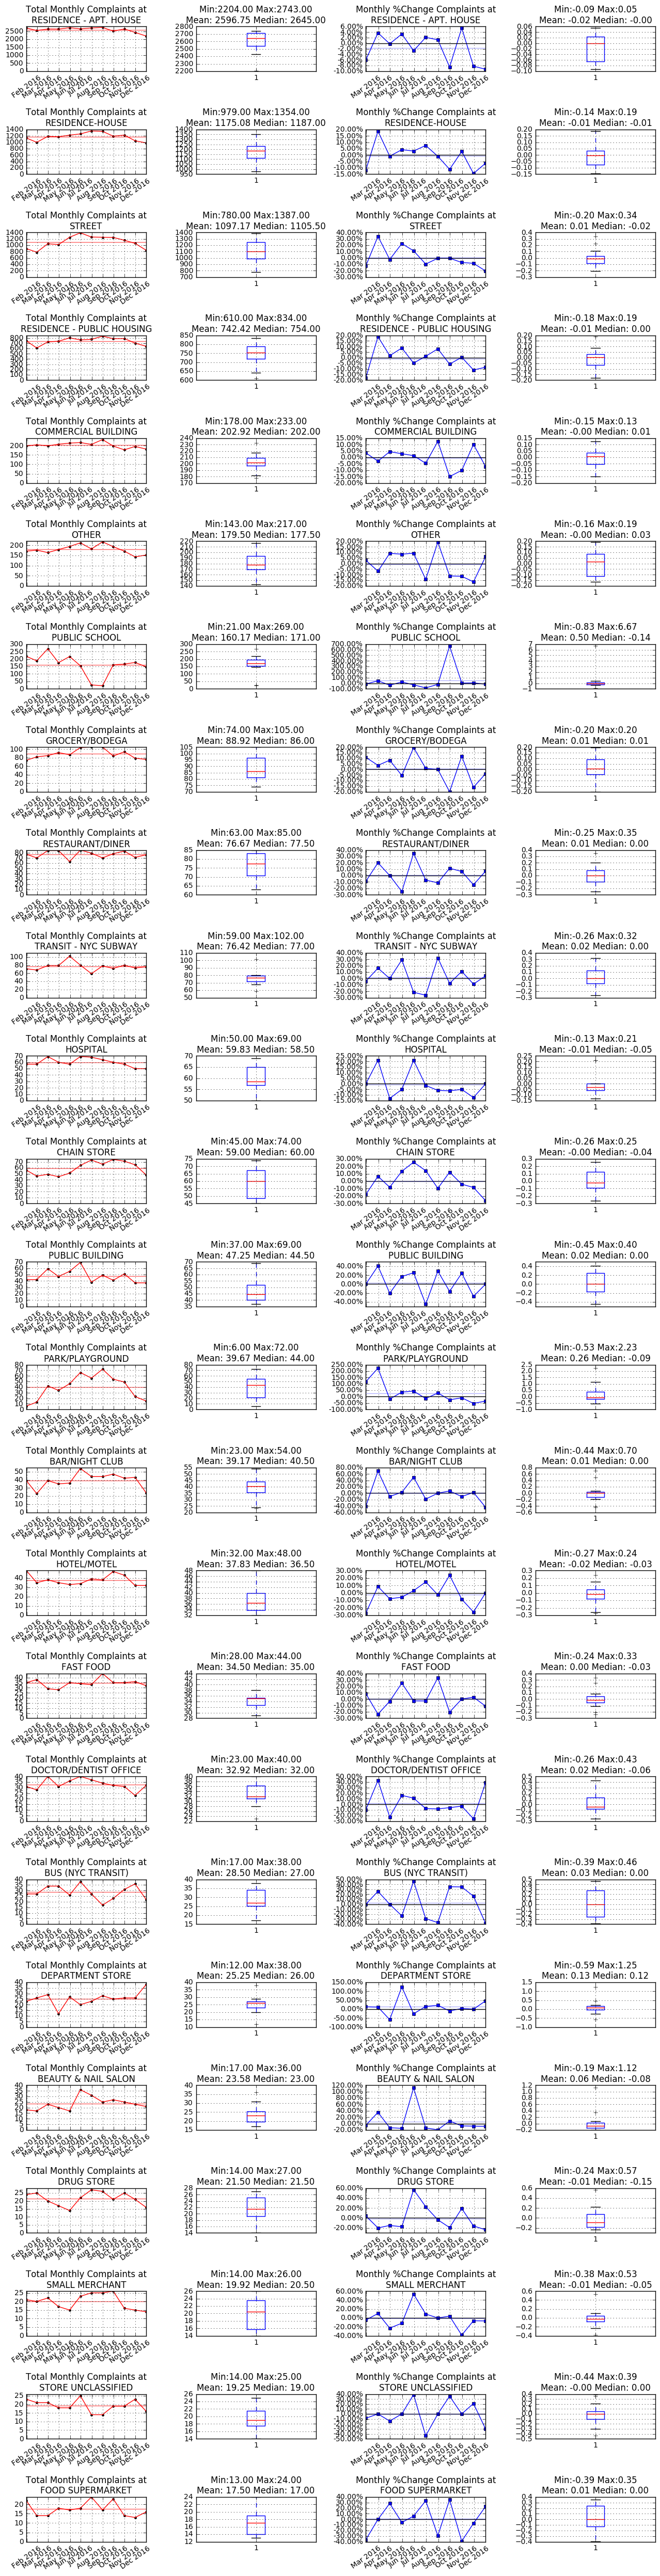

In [51]:
# TO DO: order charts below by sum of percChange DESC

descArr = harassmentDataTotals.reset_index()['PREM_TYP_DESC'].tolist()
descArr = descArr[:25]
plt.rcParams["figure.figsize"] = [13,len(descArr)*2]
plt.title('Monthly Total and % Change of Number of Harrasment Complaints per Reported Location')
i = 1

for desc in descArr:
    tempDF = pandas.DataFrame(harassmentDataTimeSeries[(harassmentDataTimeSeries['PREM_TYP_DESC'] == desc)]) 
    tempDF = tempDF.set_index(pandas.DatetimeIndex(tempDF['CMPLNT_FR_DT']))
    tempDF = tempDF.resample("M").sum()
    plt.subplot(len(descArr), 4, i)
    plt.tight_layout()
    plt.plot(tempDF, 'k.', tempDF, 'r-')
    plt.xticks(rotation=35)
    plt.title('Total Monthly Complaints at\n'+desc)
    plt.ylim(ymin=0)
    plt.grid()
    plt.axhline(tempDF.COUNT.mean(), color='red', alpha=0.6)
    i+=1       
    plt.subplot(len(descArr), 4, i)
    plt.tight_layout()
    plt.boxplot(tempDF['COUNT'])
    plt.title('Min:'+str('%.2f' % tempDF.min().COUNT)+' Max:'+str('%.2f' % tempDF.max().COUNT)+'\nMean: '+str('%.2f' % tempDF.mean().COUNT)+' Median: '+str('%.2f' % tempDF.median().COUNT))
    plt.grid()
    i+=1
    tempDF = tempDF.pct_change();
    ax = plt.subplot(len(descArr), 4, i)
    plt.plot(tempDF, 'bs', tempDF, 'b-', markersize=5)
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.title('Monthly %Change Complaints at\n'+desc)
    plt.grid()
    plt.axhline(0, color='black')
    plt.axhline(tempDF.COUNT.mean(), color='blue', alpha=0.3)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
    i+=1
    plt.subplot(len(descArr), 4, i)
    plt.tight_layout()
    plt.boxplot(tempDF['COUNT'].fillna(0))
    plt.title('Min:'+str('%.2f' % tempDF.min().COUNT)+' Max:'+str('%.2f' % tempDF.max().COUNT)+'\nMean: '+str('%.2f' % tempDF.mean().COUNT)+' Median: '+str('%.2f' % tempDF.median().COUNT))
    plt.grid()
    i+=1

In [52]:
streetHarassmentData = harassmentData[harassmentData['PREM_TYP_DESC'] == 'STREET']
streetHarassmentData = pandas.DataFrame(streetHarassmentData.groupby(['Latitude','Longitude'])['COUNT'].sum())
streetHarassmentData = streetHarassmentData.reset_index()
streetHarassmentData = streetHarassmentData.round(2)
streetHarassmentData = pandas.DataFrame(streetHarassmentData.groupby(['Latitude','Longitude'])['COUNT'].sum())
streetHarassmentData = streetHarassmentData.reset_index()

map_2 = folium.Map(location=[40.729771, -73.997263], tiles='Stamen Toner', zoom_start=11)
lat_list = streetHarassmentData['Latitude'].tolist()
lon_list = streetHarassmentData['Longitude'].tolist()
con_list = streetHarassmentData['COUNT'].tolist()

for i in range(0, len(lat_list)):
    folium.CircleMarker(
        location=[lat_list[i],lon_list[i]], 
        radius=con_list[i]*10, 
        color='#8B0000', 
        fill_color='#8B0000'
    ).add_to(map_2)       

map_2

In [53]:
streetHarassmentData = harassmentData[harassmentData['PREM_TYP_DESC'] == 'RESIDENCE-HOUSE']
streetHarassmentData = pandas.DataFrame(streetHarassmentData.groupby(['Latitude','Longitude'])['COUNT'].sum())
streetHarassmentData = streetHarassmentData.reset_index()
streetHarassmentData = streetHarassmentData.round(2)
streetHarassmentData = pandas.DataFrame(streetHarassmentData.groupby(['Latitude','Longitude'])['COUNT'].sum())
streetHarassmentData = streetHarassmentData.reset_index()

map_2 = folium.Map(location=[40.729771, -73.997263], tiles='Stamen Toner', zoom_start=11)
lat_list = streetHarassmentData['Latitude'].tolist()
lon_list = streetHarassmentData['Longitude'].tolist()
con_list = streetHarassmentData['COUNT'].tolist()

for i in range(0, len(lat_list)):
    folium.CircleMarker(
        location=[lat_list[i],lon_list[i]], 
        radius=con_list[i]*10, 
        color='#6699ff', 
        fill_color='#6699ff'
    ).add_to(map_2)       

map_2

In [54]:
streetHarassmentData = harassmentData[harassmentData['PREM_TYP_DESC'] == 'COMMERCIAL BUILDING']
streetHarassmentData = pandas.DataFrame(streetHarassmentData.groupby(['Latitude','Longitude'])['COUNT'].sum())
streetHarassmentData = streetHarassmentData.reset_index()
streetHarassmentData = streetHarassmentData.round(2)
streetHarassmentData = pandas.DataFrame(streetHarassmentData.groupby(['Latitude','Longitude'])['COUNT'].sum())
streetHarassmentData = streetHarassmentData.reset_index()

map_2 = folium.Map(location=[40.729771, -73.997263], tiles='Stamen Toner', zoom_start=11)
lat_list = streetHarassmentData['Latitude'].tolist()
lon_list = streetHarassmentData['Longitude'].tolist()
con_list = streetHarassmentData['COUNT'].tolist()

for i in range(0, len(lat_list)):
    folium.CircleMarker(
        location=[lat_list[i],lon_list[i]], 
        radius=con_list[i]*10, 
        color='#ffbf00', 
        fill_color='#ffbf00'
    ).add_to(map_2)       

map_2